<a href="https://colab.research.google.com/github/aaalexlit/tf-advanced-techniques-spec/blob/main/course_1_custom_models%20/Week_1_Multi_output_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab to build models with more than one output
## Dataset
https://archive.ics.uci.edu/ml/datasets/energy+efficiency

### Data Set Information:

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

### Attribute Information:

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 

Specifically:  
X1 Relative Compactness  
X2 Surface Area  
X3 Wall Area  
X4 Roof Area  
X5 Overall Height  
X6 Orientation  
X7 Glazing Area  
X8 Glazing Area Distribution
  
y1 Heating Load  
y2 Cooling Load  




## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

For data conversion and visualization

In [3]:
# convert output labels to numpy arrays
def format_output(data):
  y1 = data.pop('Y1')
  y1 = np.array(y1)
  y2 = data.pop('Y2')
  y2 = np.array(y2)
  return y1, y2


#standardize the input 
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlabel('True values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  # plot diagonal line
  plt.plot([-100, 100], [-100, 100])
  plt.show()


def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history[f'val_{metric_name}'], color='green', label=f'val_{metric_name}')
  plt.show()

## Prepare the data
Download the dataset and format it for training

In [11]:
URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas read_excel
df = pd.read_excel(URI)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Remove the dependent variables from stats
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

# Extract labels from the dataset and convert them to numpy arrays
train_Y = format_output(train)
test_Y = format_output(test)

# Standadize the features
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the model
Notice that we can specify a list of outputs (i.e. [y1_output, y2_output]) when we instantiate the Model() class.

In [14]:
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units=128, activation='relu', name='first_dense')(input_layer)
second_dense = Dense(units=128, activation='relu', name='second_dense')(first_dense)

y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=128, activation='relu', name='third_dense')(second_dense)

y2_output = Dense(units=1, name='y2_output')(third_dense)

model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 first_dense (Dense)            (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 second_dense (Dense)           (None, 128)          16512       ['first_dense[0][0]']            
                                                                                                  
 third_dense (Dense)            (None, 128)          16512       ['second_dense[0][0]']           
                                                                                              

## Plot the model

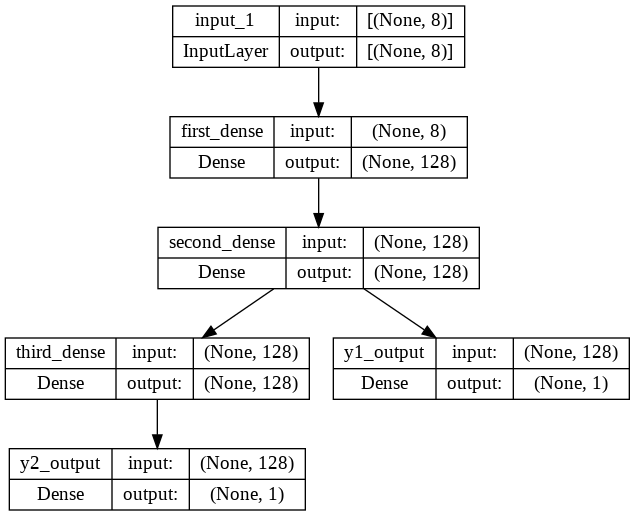

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Configure parameters
Here it's redundant, but we specify the optimizer as well as the loss and metrics for each output to show that it can be done

In [15]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(), 
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the model

In [18]:
train

,X1,X2,X3,X4,X5,X6,X7,X8
267,0.74,686.0,245.0,220.50,3.5,5,0.10,5
399,0.82,612.5,318.5,147.00,7.0,5,0.25,3
335,0.62,808.5,367.5,220.50,3.5,5,0.25,1
409,0.74,686.0,245.0,220.50,3.5,3,0.25,3
445,0.82,612.5,318.5,147.00,7.0,3,0.25,4
...,...,...,...,...,...,...,...,...
507,0.74,686.0,245.0,220.50,3.5,5,0.25,5
19,0.79,637.0,343.0,147.00,7.0,5,0.00,0
339,0.98,514.5,294.0,110.25,7.0,5,0.25,2
264,0.74,686.0,245.0,220.50,3.5,2,0.10,5


In [19]:
history = model.fit(norm_train_X, 
                    train_Y,
                    epochs=500,
                    batch_size=10, 
                    validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 2s 11ms/step - loss: 242.1826 - y1_output_loss: 119.5124 - y2_output_loss: 122.6701 - y1_output_root_mean_squared_error: 10.9322 - y2_output_root_mean_squared_error: 11.0757 - val_loss: 248.6841 - val_y1_output_loss: 70.7498 - val_y2_output_loss: 177.9343 - val_y1_output_root_mean_squared_error: 8.4113 - val_y2_output_root_mean_squared_error: 13.3392
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 37.5608 - y1_output_loss: 13.4972 - y2_output_loss: 24.0636 - y1_output_root_mean_squared_error: 3.6739 - y2_output_root_mean_squared_error: 4.9055 - val_loss: 26.9915 - val_y1_output_loss: 10.3992 - val_y2_output_loss: 16.5923 - val_y1_output_root_mean_squared_error: 3.2248 - val_y2_output_root_mean_squared_error: 4.0734
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 29.2480 - y1_output_loss: 11.0965 - y2_output_loss: 18.1514 - y1_output_root_mean_squared_error: 3.3311 - y2_output_root_mea

## Evaluate model and plot Metrics

In [20]:
model.evaluate(norm_test_X, test_Y)

5/5 [==============================] - 0s 3ms/step - loss: 1.8681 - y1_output_loss: 0.4862 - y2_output_loss: 1.3819 - y1_output_root_mean_squared_error: 0.6973 - y2_output_root_mean_squared_error: 1.1756


[1.8681414127349854,
 0.4862003028392792,
 1.381941318511963,
 0.6972806453704834,
 1.1755599975585938]

5/5 [==============================] - 0s 3ms/step


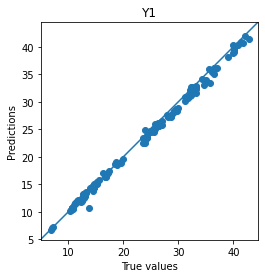

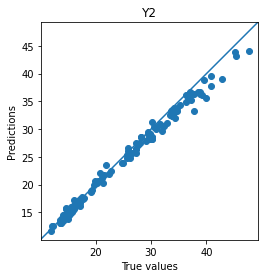

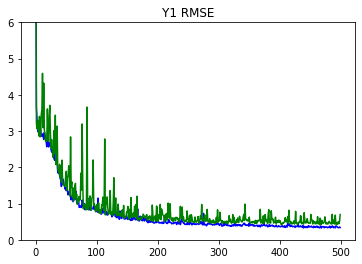

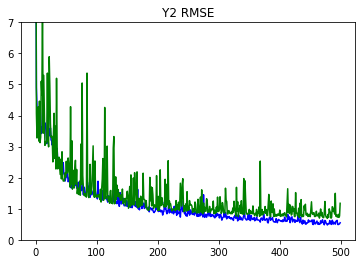

In [21]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)